### 학습 목표

- 타이타닉 데이터를 활용해서 생존자 예측 실습을 진행
- Kaggle 사이트에 결과를 제출하여 높은 점수를 받는게 목표
- 데이터를 전처리하는 기법에 대해 학습

# 머신러닝 과정

- 1. 문제를 정의
- 2. 데이터 수집
- 3. 데이터 전처리
- 4. EDA(탐색적 데이터 분석) -> 특성 선택, 특성 삭제
- 5. 모델 선택및 하이퍼파라미터 조정
- 6. 모델 예측 및 평가   

In [68]:
# 1. 문제 정의
# -> 타이타닉 생존자를 예측해서 Kaggle에 참여한다.

# 2. 데이터 수집
# -> Kaggle에서 제공

In [69]:
# 라이브러리 불러오기

# 데이터 공학(전처리)를 위해서 사용
import numpy as np
import pandas as pd

# 데이터 시각화를 위해서 사용
# matplotlib의 단점 : 설정의 자유도가 높지만, 반대로 설정해야하는 내용들이 너무 많다.
# ->  우리는 데이터 시가화를 간단히 하고 싶다. 기본적으로 꾸며져있는 시각화 라이브러리가 필요하다.
# -> 그래서 seaborn이 만들어짐
import matplotlib.pyplot as plt
import seaborn as sns

In [70]:
# 데이터 불러오기

train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [71]:
# 5개의 데이터를 샘플링

# set_index(), pd.read_csv('파일명' index_col = '원하는 컬럼명')
# train 데이터프레임에서 PassengerId를 인덱스로 설정
# set_index는 바뀐 결과물만 보여주고, 원본 데이터에는 영향 X
# inplace = True -> 원본 데이터에 영향 O
# train = train.set_index('PassengerId', drop=True)

# 상위 5개 행 출력
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [72]:
# 타이타닉 데이터 컬럼 설명
# Pclass : 티켓의 등급
# SibSp : 배우자와 형제수
# Parch : 자식과 부모를 합친 수
# Fare : 티켓의 요금
# Embarked : 탑승항
# Survived(정답) : 탑승자가 생존했는지 유무


In [73]:
# 데이터 확인
# 1. train과 test의 차이점
# 결측치가 존재한다!
# 2. train과 test 각각의 문제점
# train : Age, Cabin, Embarked에 결측치가 존재한다!
# test : Age, Fare, Cabine에 결측치가 존재한다!
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.1+ KB


### 채워줄 결측치의 내용
- 1. dropna: 결측치가 존재하는 행의 데이터를 삭제
- 2. 문자데이터 : 일반저긍로 최빈값(가장 많은 값)으로 채워준다. 
- 3. 숫자데이터 : EDA(데이터 시각화)를 통해서, 데이터의 분산을 확인 , 중앙값, 평균으로 채워줄지 결정해야 한다.
- 4. dropna: 결측치가 존재하는 행의 데이터를 삭제
- 5. dropna: 결측치가 존재하는 행의 데이터를 삭제

In [74]:
train['Embarked'].value_counts()

Embarked
S    644
C    168
Q     77
Name: count, dtype: int64

<Axes: xlabel='Embarked', ylabel='count'>

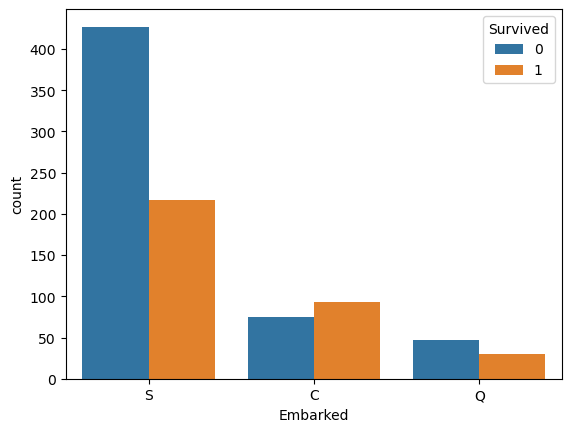

In [75]:
# Embarked를 S로 채워도 무방한지 데이터 시각화를 통해서 확인

import seaborn as sns

# 범주화된 데이터를 시각화 하기 용이한 countplot에
# countplot(data = df자료, x = 기준컬럼명, hue 관측할 컬럼명)
sns.countplot(x="Embarked", hue="Survived", data=train)

# 관측결과 : S, Q에서 탑승한 사람들은 평균적인 생존율을 가지고 이싿.
#           다만 C에서 탑승한 사람들은 조금 더 높은 생존율을 기록하고 있다.
#           -> 모델의 성능이 좋지 않아서, 전처리를 다시 했을 때는 다른 컬럼과 비교하여 데이터를 채워줄 필요가 있다.

In [76]:
# 결측치가 2개 뿐이고, S가 압도적으로 많으면서, 생존율에 큰 변화가 없기 때문에
# 결측치를 S라는 문자열로 채워준다.
#

# 하나하나 채워주는 게  아니라, 일괄적으로 같은 값을 입력
train['Embarked'].isnull().sum()
# fillna('채워줄 값')
train['Embarked'].fillna('S', inplace=True)

C:\Users\smhrd\AppData\Local\Temp\ipykernel_3888\2142494439.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['Embarked'].fillna('S', inplace=True)


In [77]:
# 결측치가 채워졌는지 확인

train['Embarked'].isnull().sum()

0

In [78]:
test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [79]:
# test 데이터의 fare(요금)
# 숫자 데이터
# fare와 관련 깊은 특성과 비교해서 전처리

# 기술통계량 확인
test['Fare'].isnull().sum()

# Fare의 분산이 크면서, 데이터의 범위가 넓기 때문에 평균 데이터가 가지는 의미가 많이 퇴색된다.
test.describe()['Fare']

count    417.000000
mean      35.627188
std       55.907576
min        0.000000
25%        7.895800
50%       14.454200
75%       31.500000
max      512.329200
Name: Fare, dtype: float64

In [80]:
# 1. pclass와 성별 컬럼을 기준으로 데이터를 확인한다.
# 2. 결측치가 있는 사람의 pclass와 성별을 확인해서 pclass와 성별에 맞는 값을 넣어준다.


# 기준으로 삼고 싶은 데이터가 복수 개라면, 리스트에 묶어서 전달한다.
pt1 = test[['Pclass','Sex','Fare']].groupby(['Pclass','Sex']).median() # 중앙값
pt1
# Pclass가 3이면서 Sex가 남자인 사람의 값을 조회
# loc인데서를 통해서 접근
# 인덱스가 2개 이상 있다면 -> 멀티 인덱스
# 해당 데이터 프레임에 접근 -> 멀티 인덱싱

# loc[행에 대한 접근, 열에 대한 접근]
# loc[('Pclass','Sex'),'Fare'] -> 멀티 인덱스

Fare
Pclass Sex             
1      female  79.02500
       male    51.86250
2      female  26.00000
       male    13.00000
3      female   8.08125
       male     7.89580

In [81]:
aa = []
aa.append((pt1.loc[(1,'male'),'Fare'],'Pclass가 1이면서 Sex가 남자인 Fare(요금)'))
aa.append((pt1.loc[(3,'female'),'Fare'],'Pclass가 3이면서 Sex가 여자인 Fare(요금)'))
aa.append((pt1.loc[(2,'male'),'Fare'],'Pclass가 2이면서 Sex가 남자인 Fare(요금)'))


for a in aa:
    print(a[1], a[0])

Pclass가 1이면서 Sex가 남자인 Fare(요금) 51.8625
Pclass가 3이면서 Sex가 여자인 Fare(요금) 8.08125
Pclass가 2이면서 Sex가 남자인 Fare(요금) 13.0


In [82]:
# isnull함수는 결측치가 잇는 데이터는 True를 반환
# boolean 인덱싱은 True를 만족하는 데이터만 조회
bool1 = test['Fare'].isnull()

# fare가 결측치인 사람의 정보를 조회


test[bool1]['Fare'] = pt1.loc[(3, 'male'), 'Fare']
test[bool1]
# Pclass가 3이면서 Sex가 남자인 Fare(요금)의 중앙값을 채워주자
# 1. fillna를 활용해서 결측치 채워주기
# test['Fare'].fillna('')
# 2. 직접 결측치를 가진 데이터에 접근해서 대입연산자로 넣어주기 



C:\Users\smhrd\AppData\Local\Temp\ipykernel_3888\3682113901.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[bool1]['Fare'] = pt1.loc[(3, 'male'), 'Fare']


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


In [95]:
test.loc[bool1, 'Fare'] = pt1.loc[(3, 'male'), 'Fare']

test[bool1]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,7.8958,NaN,S


In [98]:
testObject = test[test['PassengerId'] == 1044]

bool2 = testObject['Fare']

type(bool2)

pandas.core.series.Series

In [90]:
# train, test의 공통사항
# -> Cabin, Age 결측치 채워주기

In [112]:
# Age 컬럼 결측치 처리

# 상관관계 파악
# -> 해당 컬럼이 다른 컬럼과 비례하는지, 반비례하는지 확인하는 작업

bool3 = test['Age'].isnull()
test[bool3].count

<bound method DataFrame.count of      PassengerId  Pclass                                               Name  \
10           902       3                                   Ilieff, Mr. Ylio   
22           914       1               Flegenheim, Mrs. Alfred (Antoinette)   
29           921       3                                  Samaan, Mr. Elias   
33           925       3  Johnston, Mrs. Andrew G (Elizabeth Lily" Watson)"   
36           928       3                                Roth, Miss. Sarah A   
..           ...     ...                                                ...   
408         1300       3                    Riordan, Miss. Johanna Hannah""   
410         1302       3                             Naughton, Miss. Hannah   
413         1305       3                                 Spector, Mr. Woolf   
416         1308       3                                Ware, Mr. Frederick   
417         1309       3                           Peter, Master. Michael J   

        Sex  Age  

In [97]:
# Pclass, 성별을 기준으로 Age컬럼 채우기
# 1. 기술 통계량 확인
# -> 데이터의 분산을 확인해서, 중앙값으로 채워줄지 평균값으로 채워줄지 결정

train.describe()['Age']

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

In [108]:
train[['Pclass','Sex','Age']]

,Pclass,Sex,Age
0,3,male,22.0
1,1,female,38.0
2,3,female,26.0
3,1,female,35.0
4,3,male,35.0
...,...,...,...
886,2,male,27.0
887,1,female,19.0
888,3,female,NaN
889,1,male,26.0


In [113]:
# 2. Age컬럼을 중앙갑으로 채워주긴 할건데, Pclass와 성별을 고려하여 데이터를 채워주기
# Age컬럼을  Pclass와 성별 컬럼을 기준으로 pt2 제작
# -> 그룹화 함수(groupby)를 사용한다.


pt2 = train[['Age', 'Pclass','Sex']].groupby(['Pclass','Sex']).median()

print(pt2)

                Age
Pclass Sex         
1      female  35.0
       male    40.0
2      female  28.0
       male    30.0
3      female  21.5
       male    25.0


In [158]:
def fill_age(train) : # train 데이터를 전달

    # Age가 결측치일 경우에
    if np.isnan(train['Age']) :

        # pt2에서 결측치 데이터의 pclass 값과 성별 값을 가져오기
        
        age_data = pt2.loc[(train['Pclass'],train['Sex']), 'Age'] 
        return age_data
        
    # 결측치가 아닌 경우에
    else :
        return train['Age']

In [164]:
# train의 Age 컬럼의 결측치 채워주기
# apply함수 활용 결측치를 자동으로 채워주게끔 설계
# apply함수는 사용자가 정의한 함수를 한 행 단위로 작용하게 끔 도와주는 함수
import numpy as np
# -> def 사용자 정의 함수
#def aa():
# 해당 데이터가 결측치라면, pclass와 성별을 고려해서 pt2에서 알맞는 값을 꺼내서 넣어주고,
# 결축
    
bool3 = train['Age'].isnull()
print(len(train[bool3]))


df = train[['Age', 'Pclass','Sex']]


for i in range(len(df)):
    if np.isnan(df.iloc[i, 0]):  # NaN인지 확인
        pclass = df.iloc[i, :]['Pclass']
        sex = df.iloc[i, :]['Sex']
        age = pt2.loc[(pclass, sex), 'Age']
        df.iloc[i, 0] = age  # 수정된 값을 df에 반영

# 결과 확인
df
    



0


,Age,Pclass,Sex
0,22.0,3,male
1,38.0,1,female
2,26.0,3,female
3,35.0,1,female
4,35.0,3,male
...,...,...,...
886,27.0,2,male
887,19.0,1,female
888,21.5,3,female
889,26.0,1,male
